<a href="https://colab.research.google.com/github/tarabelo/PIAC-2526/blob/main/04%20-%20Algoritmo%20cu%C3%A1ntico%20de%20optimizaci%C3%B3n%20aproximada%20(QAOA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalamos qiskit en el notebook
!pip install qiskit[visualization] qiskit_algorithms qiskit_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.1/237.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.2 MB/s eta 0:00:00
  Created wheel for docplex: filename=docplex-2.30.251-py3-none-any.whl size=685954 sha256=5acc2f7c8863955e21b8f5701ec8bc040bc85704408931ad7d520e7164ca5ae3
  Stored in directory: /root/.cache/pip/wheels/c1/d9/5c/1d919b1e441eb

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# **Algoritmo cuántico de optimización aproximada (QAOA)**

### Contenidos

1. [Discretización de la evolución adiabática (*Trotterization*)](#trotter)
1. [Quantum Approximate Optimization Algorithm (QAOA)](#qaoa)
    - [Ejercicio 6](#ejercicio6)
1. [Programas cuadráticos con restricciones cuadráticas](#cuadraticos)
    - [Ejercicio 7](#ejercicio7)
1. [Variantes de QAOA](#variantes)

<a name="trotter"></a>
## **Discretización de la evolución adiabática (*Trotterization*)**

Podemos replicar la evolución adiabática en un computador cuántico basado en puertas discretizando la evolución continua del Hamiltoniano.

La evolución temporal de un sistema viene dada por la ecuación de Schrödinger:

$$i\hbar \frac{d}{dt}|\psi(t)\rangle = H(t)|\psi(t)\rangle$$

En general, $H(t)$ depende del tiempo. Pero en un intervalo temporal $[t_i, t_i+\Delta t]$ suficientemente pequeño podemos considerar $H(t_i)$ constante, verificándose que:

$$|\psi(t_i+\Delta t)\rangle = e^{-iH(t_i)\Delta t}|\psi(t_i)\rangle = U_i|\psi(t_i)\rangle$$

siendo $U_i = e^{-iH(t_i)\Delta t}$ una matriz unitaria.



Si discretizamos la evolución en $p = \frac{T}{\Delta t}$ pasos, podemos escribir:

$$
|\psi(t_1)\rangle = U_0|\psi(t_0)\rangle \\
|\psi(t_2)\rangle = U_1|\psi(t_1)\rangle \\
\cdots \\
|\psi(t_{p})\rangle = U_{p-1}|\psi(t_{p-1})\rangle
$$


De esta forma, el estado final del sistema será:

$$
|\psi(t_{p})\rangle = U_{p-1}U_{p-2}\cdots U_{1}U_{0}|\psi(t_0)\rangle = \left(\prod_{m=p-1}^{0} U_m\right) |\psi(t_0)\rangle =
$$



El Hamiltoniano usado en computación adiabática es:

$$H(t) = A(t)H_0 + B(t)H_c$$

por lo que resulta:

$$
|\psi(T)\rangle = \left(\prod_{m=0}^{p-1} e^{i\Delta t(A'(t_m)H_0 + B'(t_m)H_c)}\right) |\psi(0)\rangle
$$

donde $A'(t_m) = -A(t_{p-1-m})$, $B'(t_m) = -B(t_{p-1-m})$, $|\psi(T)\rangle = |\psi(t_{p})\rangle$ y $|\psi(0)\rangle = |\psi(t_{0})\rangle$

En general, dadas dos matrices $A$ y $B$, la igualdad $e^{A+B} = e^Ae^B$ solo se da si $A$ y $B$ _conmutan_, es decir si $[A,B] = AB-BA = 0$.

Si $\Delta t$ es lo suficientemente pequeño y los hamiltonianos "casi" conmutan, la formula de Lie-Trotter de primer orden permite escribir:

$$
e^{i\Delta t(A'(t_m)H_0 + B'(t_m)H_c)}
= e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c} +
\mathcal{O}(t^2) \approx e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c}
$$

Por lo tanto, el estado final del sistema se puede escribir:

$$
|\psi_f\rangle = |\psi(T)\rangle = \left(\prod_{m=0}^{p-1} e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c}\right) |\psi(0)\rangle =
\prod_{m=0}^{p-1} U_0(t_m)U_c(t_m)|\psi_0\rangle
$$

siendo las matrices unitarias:

$$
U_0(t_m) = e^{i\Delta tA'(t_m)H_0}\\
U_c(t_m) = e^{i\Delta tB'(t_m)H_c}
$$

Este procedimiento se denomina _trotterization_ y es la base de algoritmos como el QAOA.




---



---



---



<a name="qaoa"></a>
# **Quantum Approximate Optimization Algorithm (QAOA)**

QAOA (Farhi, E., Goldstone, J., \& Gutmann, S. 2014) es un lgoritmo híbrido basado en la discretización de la evolución adiabática para resolver problemas Ising.

Como ya hemos visto, el estado final del sistema despues de la evolución es:

$$
|\psi_f\rangle = |\psi(T)\rangle = \left(\prod_{m=0}^{p-1} e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c}\right) |\psi(0)\rangle =
\prod_{m=0}^{p-1} U_0(t_m)U_c(t_m)|\psi_0\rangle
$$

siendo las matrices unitarias:

$$
U_0(t_m) = e^{i\Delta tA'(t_m)H_0} = e^{i\beta_mH_0} = U_0(\beta_m)\\
U_c(t_m) = e^{i\Delta tB'(t_m)H_c} = e^{i\gamma_mH_c} = U_c(\gamma_m)
$$
con $m=0,\ldots,p-1$ y $p \ge 1$.

QAOA intenta elegir unos valores de $\beta_m$ y $\gamma_m$ que aproximen el estado $|\psi_f\rangle$ al estado base del Hamiltoniano de coste $H_c$, es decir, que minimizen $\langle\psi_f|H_c|\psi_f\rangle$.

El algoritmo QAOA parte de un Hamiltoniano de coste $H_c$ que define el problema y procede como sigue:

1. Se elige un valor de $p\ge 1$ y dos listas de valores $\boldsymbol{\beta} = (\beta_0,\ldots,\beta_{p-1})$ y $\boldsymbol{\gamma} = (\gamma_0,\ldots,\gamma_{p-1})$
1. Como $H_0$ se suele usar el _mixing Hamiltonian_ o _mixer_ $H_M$ y como estado inicial la superposición completa (aunque se pueden usar otros)
  $$H_M = -\sum_{i=0}^{n-1} X_i\quad
  |\psi_0\rangle = |+\rangle^{\otimes n}$$
2. La QPU aplica las puertas $U_0(\beta_m)U_c(\gamma_m)$, $m=0,\ldots,p-1$, y se obtiene un nuevo estado $|\psi_p\rangle$
3. En la CPU se usa un algoritmo de optimización para actualizar los parámetros $\boldsymbol{\beta}$ y $\boldsymbol{\gamma}$ intentando minimizar el valor esperado $\langle\psi_p|H_c|\psi_p\rangle$
4. Se vuelve al paso 2 hasta obtener los valores óptimos $\boldsymbol{\beta}^\ast$ y $\boldsymbol{\gamma}^\ast$
5. Usando esos valores, se obtiene el estado que minimiza la solución

El proceso de optimización de los parámetros puede ser un simple gradiente descendente, en el que cada parámetro se actualiza en la dirección que conduzca al mayor descenso del valor esperado, u otros método de optimización más sofisticados.



### Obtención del valor esperado

Dado un estado genérico en la base $Z$, $|\psi\rangle=\sum_i a_i|x_i\rangle$, el valor esperado de un Hamiltoniano $H$ es:

$$
\langle\psi|H|\psi\rangle = \left(\sum_j a^\star_j\langle x_j|\right)|H|
\left(\sum_i a_i|x_i\rangle\right) =
\sum_j\sum_i a^\star_j a_i \langle x_j|H|x_i\rangle
$$

Como $H_c$ es un hamiltoniano Ising $⇒$ es diagonal, por lo que los elemento de la base son autovectores:

$$
H_c|x_i\rangle = \lambda_i |x_i\rangle
$$

Por tanto:

$$
\langle\psi_p|H_c|\psi_p\rangle = \sum_j\sum_i a^\star_j a_i \langle x_j|\lambda_i|x_i\rangle = \sum_j\sum_i a^\star_j a_i \lambda_i \langle x_j|x_i\rangle =
\sum_i |a_i|^2 \lambda_i = \sum_i P(i) \langle x_i|H_c|x_i\rangle
$$

Es decir, podemos estimar el valor esperado tomando medidas del estado $|\psi_p\rangle$. El cálculo de $\langle x|H_c|x\rangle$ para un estado de la base es trivial, como vimos en la sección 2.

## Construcción de $U_0(\beta)$ y $U_c(\gamma)$

#### Puertas para $U_0(\beta)$

Si tenemos $n$ cúbits, y dado que las matrices $X$ conmutan tenemos:

$$U_0(\beta) = e^{i\beta H_0} = e^{-i\beta\sum_{i=0}^{n-1} X_i} = \prod_{i=0}^{n-1}e^{-i\beta X_i}$$

Y recordando que la puerta de rotación $R_x(\theta) = e^{-i\theta X/2}$, se tiene:

$$U_0(\beta) = \prod_{i=0}^{n-1} R_x^{(i)}(2\beta)$$

La puerta $R_x^{(i)}$ indica que se aplica una $R_x$ al cúbit $i$ y la identidad al resto $\implies$ el producto equivale a aplicar una puerta $R_x(2\beta)$ a cada uno de los cúbits.

#### Puertas para $U_c(\gamma)$

El Hamiltoniano de coste de un problema Ising es:


$$H_c = -\sum_{i,j = 0}^{n-1} J_{ij}Z_iZ_j -\sum_{i = 0}^{n-1} h_i Z_i$$

siendo $J_{ij}$ y $h_i$ números reales.

Ya que las matricez $Z$ conmutan, podemos escribir

$$
U_c(\gamma) = e^{i\gamma H_c} = e^{-i\gamma(\sum_{i,j = 0}^{n-1} J_{ij}Z_iZ_j +\sum_{i = 0}^{n-1} h_i Z_i)} =
\prod_{i,j = 0}^{n-1}e^{-i\gamma J_{ij}Z_iZ_j}\prod_{i=0}^{n-1}e^{-i\gamma h_i Z_i}
$$

El segundo término se puede implementar con puertas $R_z(\theta) = e^{-i\theta Z/2}$.


Para el primer término, $Z_iZ_j$ representa aplicar una puerta $Z$ a los cúbits $i$ y $j$ y la identidad al resto:

$$
Z_iZ_j = I\otimes\ldots\otimes Z\otimes\ldots\otimes Z \otimes\ldots I = Z_i\otimes Z_j
$$

Y el término $e^{-i\gamma J_{ij}Z_i\otimes Z_j}$ corresponde a una [puerta Ising ZZ](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZZGate.html#qiskit.circuit.library.RZZGate) entre los cúbits $i$ y $j$:

$$
R_{ZZ}(\theta) = \exp\left(-i\frac{\theta}{2}(Z\otimes Z)\right) =
\exp{\left(-i\frac{\theta}{2}\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix} \right)}=
\begin{bmatrix}
e^{-i\theta/2} & 0 & 0 & 0\\
0 & e^{i\theta/2} & 0 & 0\\
0 & 0 & e^{i\theta/2} & 0\\
0 & 0 & 0 & e^{-i\theta/2}\\
\end{bmatrix}
$$

Con lo que queda:

$$
U_c(\gamma) = \prod_{i,j = 0}^{n-1} R_{ZZ}^{(i,j)}(2\gamma J_{ij})\prod_{i=0}^{n-1}R_z^{(i)}(2\gamma h_i)
$$


## Ejemplo 1: Circuito QAOA para un Hamiltoniano Ising

Obtener el circuito QAOA para un paso ($p$=1) del Hamiltoniano Ising:

$$
H_c = 3Z_2Z_0 - Z_2Z_1 + 2Z_0
$$

Necesitamos 3 cúbits, y el estado que queremos conseguir será:

$$
U_0(\beta_1)U_c(\gamma_1)U_0(\beta_0)U_c(\gamma_0) |+\rangle^{\otimes 3}
$$

Con

$$
U_0(\beta_i) = \prod_{i=0}^{2} R_x^{(i)}(2\beta_i) = R_x^{(0)}(2\beta_i)\otimes R_x^{(1)}(2\beta_i)\otimes R_x^{(2)}(2\beta_i)
$$

$$
U_c(\gamma_i) = \prod_{i,j = 0}^{2} R_{ZZ}^{(i,j)}(2\gamma_i J_{ij})\prod_{i=0}^{2}R_z^{(i)}(2\gamma_i h_i) = (R_{ZZ}^{(2,0)}(6\gamma_i)\otimes R_{ZZ}^{(2,1)}(-2\gamma_i))(R_z^{(0)}(4\gamma_i))
$$

El circuito sería:

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

n = 3

beta = Parameter('β')
gamma = Parameter('γ')

qc = QuantumCircuit(n)

# Estado superpuesto
qc.h(range(3))

# Puertas U_c
qc.rzz(6*gamma, 2, 0)
qc.rzz(-2*gamma, 2, 1)
qc.rz(4*gamma, 0)

# puertas U_0
for i in range(3):
  qc.rx(2*beta, i)

qc.draw('mpl')

Podemos usar la implementación de QAOA de Qiskit para obtener este mismo circuito

In [ ]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

# Expresamos el problema como un operador Hamiltoniano
Hc = SparsePauliOp.from_list([("ZIZ", 3), ("ZZI", -1), ("IIZ", 2)])

# Creamos el ansatz QAOA
ansatz = QAOAAnsatz(Hc, reps=1)

display(ansatz.draw("mpl"))
display(ansatz.decompose(reps=2).draw("mpl"))

La puerta $U_2$ es una rotación de 1 cúbit generalizada, de la forma:

$$
U(\theta, \phi, \lambda) =
\begin{pmatrix}
\cos\left(\frac{θ}{2}\right)          & -e^{i\lambda}\sin\left(\frac{θ}{2}\right) \\
e^{i\phi}\sin\left(\frac{θ}{2}\right) & e^{i(\phi + \lambda)}\cos\left(\frac{θ}{2}\right)
\end{pmatrix}
$$

Así, una puerta $H$ es equivalente a:

$$
H = U\left(\frac{\pi}{2}, 0, \pi\right) = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1          & -e^{i\pi} \\
e^{i0} & e^{i(0 + \pi)}
\end{pmatrix} =
\frac{1}{\sqrt{2}}\begin{pmatrix}
1          & 1 \\
1 & -1
\end{pmatrix}
$$

## Ejemplo 2: Encontrar el estado que minimiza el Hamiltoniano anterior

#### a) Resolverlo por fuerza bruta

In [ ]:
from qiskit.quantum_info import Statevector

# Creamos una lista con todos los estados base para n cúbits
estados = [Statevector.from_int(i, dims=2**n) for i in range(2**n)]

# Obtenemos los valores esperados para todos los posibles estados
evs = {}
for i in range(2**n):
  evs[np.binary_repr(i,n)] = estados[i].expectation_value(Hc).real

# Obtenemos el estado con menor valor esperado
min_state = min(evs, key=evs.get)
print(evs)
print("Estado que minimiza Hc = {}".format(min_state))
print("Valor esperado <{}|Hc|{}> = {}".format(min_state, min_state, evs[min_state]))

#### b) Resolverlo con QAOA

Usar el algoritmo QAOA con el circuito anterior para encontrar el estado solución del problema.

Usaremos un *Estimator*  para encontrar el valor esperado del Hamiltoniano de coste.

El uso de cualquier versión de Estimator es similar:

- Se crea un objeto de la clase Estimator que se vaya a usar (que puede incluir parámetros)
- Se llama al método run con una lista de PUBS (Primitive Unified Blocs)

El PUB de un Estimator es una lista o tupla de dos a cuatro elementos:

- Un circuito cuántico (que puede ser parametrizado)
- Uno o más observables (Pauli, SparsePauliOp, string)
- Una colección de parámetros para el circuito (opcional)
- Opcionalmente, la precisión de la estimación (opcional)

Cada PUB (circuito, observables, valores de parámetros, precisión) de la lista que se pasa al método run, produce su propio resultado. Así, se pueden ejecutar diferentes combinaciones con una sola llamada al método run().

In [ ]:
# @title Definimos una función que devuelve el valor esperado del hamiltoniano de coste al aplicar el circuito
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

  # Creamos el PUB(circuito, observable, parámetros=)
  pub = (ansatz, hamiltonian, params)

  # Al método run hay que pasarle una lista de PUBS aunque sea de un solo elemento
  job = estimator.run([pub])

  # Job devuelve un array de resultados, nos quedamos con el primero
  results = job.result()[0]

  # evs: lista de ExpectedValues (uno solo en este caso)
  cost = results.data.evs

  # objetive_func_cvals es una lista global en la vamos metiendo todos los valores que vamos obteniendo para ver su evolución
  objective_func_vals.append(cost)

  return cost

Usamos una función de miminización de ScyPy (scipy.optimize.minimize). Como algoritmo de optimización usamos [COBYLA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.COBYLA.html#qiskit_algorithms.optimizers.COBYLA) (*Constrained Optimization By Linear Approximation optimizer*)

In [ ]:
#@title Resolvemos usando el StateVectorEstimator de Qiskit y Scipy
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

# Parámetros iniciales
initial_gamma = np.pi
initial_beta = np.pi / 2

init_params = [initial_beta, initial_gamma]

# Creamos el objeto estimator
estimador = StatevectorEstimator()

# Llamamos a la funcion para obtener el valor esperado
objective_func_vals = []
result = minimize(
        fun = cost_func_estimator,
        x0 = init_params,
        args=(ansatz, Hc, estimador),
        method="COBYLA",
        tol=1e-2
    )
print(result)

In [ ]:
print("Parametros que obtienen el mínimo: β_m = {}, γ_m = {}".format(result.x[0], result.x[1]))

In [ ]:
# Vemos la evolución del minimizador
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Recreamos el circuito con los parámetros obtenidos y le añadimos medidas:

In [ ]:
circuito_final = ansatz.assign_parameters(result.x)

# Añadimos las medidas
circuito_final.measure_all()
circuito_final.decompose(reps=2).draw('mpl')

Ejecutamos el circuito y usamos un sampler para obtener el estado más frecuente.

In [ ]:
# Usamos el sampler base de Qiskit (basado en Statevector)
from qiskit.primitives import StatevectorSampler

def circuit_sampler(circuit, sampler, shots=10000):

  pub = (circuit,)
  job = sampler.run([pub])

  # counts_int: Diccionario con claves=estados (binario), valor=ocurrencias
  counts = job.result()[0].data.meas.get_counts()

  # Probabilidades de cada estado (como diccionario Python)
  # Diccionario con claves=estados (binario), valor=probabilidad
  final_distribution = {key: val / shots for key, val in counts.items()}

  # Estado con mayor probabilidad
  min_state = max(final_distribution, key=final_distribution.get)

  return(min_state, final_distribution)


In [ ]:
# Lo ejecutamos con un StatevectorSampler
sampler = StatevectorSampler()
min_state, data_distribution = circuit_sampler(circuito_final, sampler)

# Valor esperado del Hc en ese estado
ev = Statevector.from_label(min_state).expectation_value(Hc).real

print("Estado que minimiza Hc = {}".format(min_state))
print("Valor esperado <{}|Hc|{}> = {}\n".format(min_state, min_state, ev))

In [ ]:
# Vemos la distribución de las muestras
from qiskit.visualization import plot_histogram
display(plot_histogram(data_distribution))

#### c) Resolverlo usando la implementación de QAOA de Qiskit

Usamos la implementación de [QAOA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html) del paquete [qiskit_algorithms](https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.html).

In [ ]:
from qiskit_algorithms import QAOA
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 10598

# Parámetros iniciales
initial_gamma = np.pi
initial_beta = np.pi / 2

init_params = [initial_beta, initial_gamma]

# Utilizo el mismo optimizador que antes
optimizer = COBYLA()

# Tambien uso el mismo sampler
sampler = StatevectorSampler()

# Defino el algoritmo
qaoa = QAOA(sampler=sampler, optimizer=optimizer, initial_point=init_params)

# Obtengo el mínimo autovalor del Hamiltoniano
result = qaoa.compute_minimum_eigenvalue(Hc)

min_state = result.best_measurement['bitstring']
ev = result.best_measurement['value']
print("Estado que minimiza Hc = {}".format(min_state))
print("Valor esperado <{}|Hc|{}> = {}\n".format(min_state, min_state, ev.real))

El circuito que utilizó:

In [ ]:
result.optimal_circuit.decompose(reps=2).draw('mpl')



---



---



---



<a name="ejercicio6"></a>
# **Ejercicio 6**:


En el ejercicio 2, habíamos expresado como QUBO el problema de la suma de subconjuntos para $S=\{-3, 2, -2, 5, 1\}$ y $T=4$. Resuélvelo usando QAOA:

a) Creando el circuito como un QAOAAnsatz y utilizando la función de minimización de Scipy

b) Usando la implementación de QAOA de qiskit_algorithms




---



---



---



<a name="cuadraticos"></a>
# **Programas cuadráticos con restricciones cuadráticas**

La librería de optimización de Qiskit incorpora una librería para resolver problemas QCQP con variables binarias y/o enteras.



**Ejemplo con variables enteras**

Minimiza $y=10x_0+20x_1+30 x_2 +  4 x_0x_1 + 2 x_0x_2 + 6 x_1x_2 + 4 x_1^2  + 2 x_2^2$

con las siguientes restricciones:

  - $x_0\in\{0,1\}$
  - $x_1, x_2 \in \mathbb{Z}, -1\le x_1 \le 1, -2\le x_2 \le 3$

Podemos expresar el problema de la siguiente forma:

Se puede escribir como:
$$
\begin{align}
\text{minimizar} &&x^T Q x + c^T x &&\\
&& && \\
\text{sujeto a} &&x_0\in\{0,1\}, x_1, x_2 \in \mathbb{Z}  &&\\
&& -1\le x_1 \le 1 \\
&& -2\le x_2 \le 3 \\
\end{align}
$$

Se puede probar fácilmente que $Q$ y $c$ en este ejemplo valen:

$$
\begin{aligned}
Q  &= \begin{bmatrix}0 & 1 & 2 \\ 3 & 4 & 5 \\ 0 & 1 & 2 \end{bmatrix}\\[10pt]
c^T &= \begin{bmatrix}10&20&30\end{bmatrix}
\end{aligned}
$$

In [3]:
from qiskit_optimization import QuadraticProgram

# Definimos el problema cuadrático
qprog = QuadraticProgram('Ejemplo')

# Fijamos el tipo de las variables y sus restricciones
qprog.binary_var(name = 'x_0')
qprog.integer_var(name = 'x_1', lowerbound = -1, upperbound = 1)
qprog.integer_var(name = 'x_2', lowerbound = -2, upperbound = 3)

# Matriz Q y vector c
Q = [[0,1,2],[3,4,5],[0,1,2]]
c = [10,20,30]

# Expresamos el problema como una minimización
qprog.minimize(quadratic = Q, linear = c)

print(qprog.prettyprint())

Problem name: Ejemplo

Minimize
  4*x_0*x_1 + 2*x_0*x_2 + 4*x_1^2 + 6*x_1*x_2 + 2*x_2^2 + 10*x_0 + 20*x_1
  + 30*x_2

Subject to
  No constraints

  Integer variables (2)
    -1 <= x_1 <= 1
    -2 <= x_2 <= 3

  Binary variables (1)
    x_0



Este problema puede ser resuelto mediante QAOA usando el método [`MinimumEigenOptimizer`](https://qiskit-community.github.io/qiskit-optimization/stubs/qiskit_optimization.algorithms.MinimumEigenOptimizer.html) que se encarga de convertir el programa cuadrático a un Hamiltoniano Ising y de realizar la optimización, usando el solver que se le indique.

Este solver debe ser un objeto de una clase que implemente la interfaz [`MinimumEigenSolver`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.MinimumEigensolver.html). Los objetos de esta clase implementan un método `compute_minimum_eigenvalue` para obtener el autovalor mínimo.

Clases que implementan esta interfaz son [`VQE`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQE.html) o [`QAOA`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html) entre otras.


Seleccionamos el Sampler y el optimizador

In [23]:
from qiskit_algorithms import QAOA
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.optimizers import ADAM
from qiskit_optimization.algorithms import MinimumEigenOptimizer

sampler = StatevectorSampler()

optimizer = ADAM()

# Creamos el problema QAOA
qaoa = QAOA(sampler=sampler, optimizer=optimizer, initial_point=[0.0, 0.0])

# Creamos el optimizador
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)

CPU times: user 203 µs, sys: 0 ns, total: 203 µs
Wall time: 207 µs


Resolvemos el problema usando el optimizador cuántico:
**NOTA**: Este código tarda mucho en ejecutarse (más de 1 hora).

In [ ]:
%%time
# Usamos ese optimizador sobre el problema anterior
result = eigen_optimizer.solve(qprog)

print(result)

Podemos comprobar que el resultado es correcto usando un minimizador clásico, en concreto el [`NumPyMinimumEigensolver`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.NumPyMinimumEigensolver.html)

In [24]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

np_solver = NumPyMinimumEigensolver()
np_optimizer = MinimumEigenOptimizer(min_eigen_solver = np_solver)

result = np_optimizer.solve(qprog)
print(result)

fval=-56.0, x_0=0.0, x_1=-1.0, x_2=-2.0, status=SUCCESS


Qiskit proporciona utilidades que permiten convertir el QuadraticProgram en un QUBO:

In [5]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qprog)
print(qubo)

minimize 4*x_0*x_1@0 + 4*x_0*x_1@1 + 2*x_0*x_2@0 + 4*x_0*x_2@1 + 4*x_0*x_2@2 + 4*x_1@0^2 + 8*x_1@0*x_1@1 + 6*x_1@0*x_2@0 + 12*x_1@0*x_2@1 + 12*x_1@0*x_2@2 + 4*x_1@1^2 + 6*x_1@1*x_2@0 + 12*x_1@1*x_2@1 + 12*x_1@1*x_2@2 + 2*x_2@0^2 + 8*x_2@0*x_2@1 + 8*x_2@0*x_2@2 + 8*x_2@1^2 + 16*x_2@1*x_2@2 + 8*x_2@2^2 + 2*x_0 + 16*x_2@0 + 32*x_2@1 + 32*x_2@2 - 56 (6 variables, 0 constraints, 'Ejemplo')


Y también obtener el modelo Ising de un QUBO:

In [7]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Hamiltoniano Ising:")
print(qubitOp)

Offset: 27.5
Hamiltoniano Ising:
SparsePauliOp(['IIIIIZ', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIIZI', 'IIIZIZ', 'IIIZII', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[ -5.5+0.j, -16.5+0.j, -33. +0.j, -33. +0.j,   1. +0.j, -12.5+0.j,
   1. +0.j, -12.5+0.j,   0.5+0.j,   1. +0.j,   1. +0.j,   2. +0.j,
   1.5+0.j,   3. +0.j,   3. +0.j,   1.5+0.j,   3. +0.j,   3. +0.j,
   2. +0.j,   2. +0.j,   4. +0.j])




---



---



---



<a name="ejercicio7"></a>
# **Ejercicio 7**:

**MAXCUT** como problema QCQP

Hemos visto como expresar en problema MAXCUT como un QUBO (forma $f(x) = x^TQx$). Es también posible expresarlo como un problema QCQP de variables binarias:

$$
f(x) = c^T x + x^T A x
$$

siendo $A$ la matriz de adyacencias del grafo.

a. Obtén la expresión para el vector $c$

b. Haz una función que reciba una matriz de adyacencias de un grafo no dirigido (como un array de numpy) y resuelva el problema MAXCUT usando módulo de optimización de Qiskit
   - La función debe verificar que la matriz es una matriz de adyacencias correcta.




---



---



La librería [`qiskit_optimization.applications`](https://qiskit-community.github.io/qiskit-optimization/apidocs/qiskit_optimization.applications.html) contiene implementaciones de diferentes problemas clásicos de optimización, como el Maxcut, entre otros

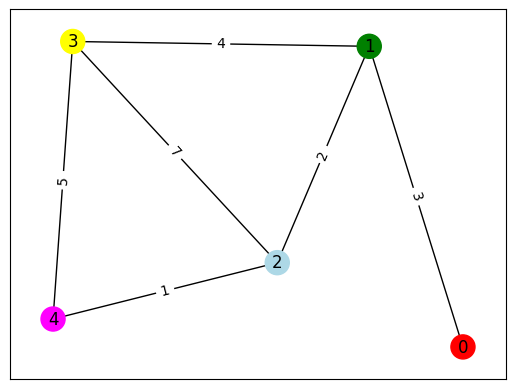

In [11]:
# Definimos un grafo con networkx
import numpy as np
import networkx as nx  # Librería para manejar grafos

# Ejemplo de grafo con 5 nodos
nnodes = 5
G = nx.Graph()
# Añade nodos y aristas
G.add_nodes_from(np.arange(0,nnodes,1))
edges = [(0,1,3),(1,2,2),(1,3,4),(2,4,1),(2,3,7),(3,4,5)]
G.add_weighted_edges_from(edges)

# Mostramos el grafo
layout = nx.random_layout(G,seed=10)
colors = ['red', 'green', 'lightblue', 'yellow', 'magenta']
nx.draw_networkx(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

In [12]:
from qiskit_optimization.applications import Maxcut
# Crea un problema Maxcut a partir del grafo

max_cut = Maxcut(G)

# Convierte el maxcut en un problema cuadrático
qp = max_cut.to_quadratic_program()

print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -6*x_0*x_1 - 4*x_1*x_2 - 8*x_1*x_3 - 14*x_2*x_3 - 2*x_2*x_4 - 10*x_3*x_4
  + 3*x_0 + 9*x_1 + 10*x_2 + 16*x_3 + 6*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



Lo resolvemos usando el minimizador clásico `NumPyMinimumEigensolver`:

In [22]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

np_solver = NumPyMinimumEigensolver()
np_optimizer = MinimumEigenOptimizer(min_eigen_solver = np_solver)

result = np_optimizer.solve(qp)
print(result)
# Obtiene el corte a partir del resultado
print("Corte "+str(max_cut.interpret(result)))

fval=19.0, x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=1.0, status=SUCCESS
Corte [[0, 3], [1, 2, 4]]


En este caso, como todas las variables son binarias y no hay restricciones, ya es un QUBO, por lo que podemos obtener directamente la versión Ising:



In [14]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Hamiltoniano Ising:")
print(str(qubitOp))

Offset: -11.0
Hamiltoniano Ising:
SparsePauliOp(['IIIZZ', 'IIZZI', 'IZIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[1.5+0.j, 1. +0.j, 2. +0.j, 3.5+0.j, 0.5+0.j, 2.5+0.j])


Podemos usar el `NumPyMinimumEigensolver` para obtener el menor autovalor:

In [25]:
energy = np_solver.compute_minimum_eigenvalue(qubitOp)
print(energy)

{   'aux_operators_evaluated': None,
    'eigenstate': Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2)),
    'eigenvalue': np.complex128(-8+0j)}


In [31]:
print("Autovalor:" + str(energy.eigenvalue))
print("Autovector: ")
display(energy.eigenstate.draw('latex'))
print("Valor objetivo:"+ str(energy.eigenvalue.real+offset))

Autovalor:(-8+0j)
Autovector: 


<IPython.core.display.Latex object>

Valor objetivo:-19.0




---



---



---



<a name="variantes"></a>
# **Variantes de QAOA**

- Quantum Alternating Operator Ansatz:
  - Extiende el QAOA original para permitir el uso de otros tipos de operadores como hamiltonianos de coste y _mixer_ que capturen mejor la estructura de problemas específicos
  - Hadfield, Stuart, et al. "From the quantum approximate optimization algorithm to a quantum alternating operator ansatz." Algorithms 12.2 (2019): 34. https://www.mdpi.com/1999-4893/12/2/34
- XY Mixers:
  - Estrategias para aplicar restricciones estrictas utilizando hamiltonianos XY como _mixers_
  - Wang, Zhihui, et al. "XY mixers: Analytical and numerical results for the quantum alternating operator ansatz." Physical Review A 101.1 (2020): 012320. https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.012320
- ADAPT-QAOA:
  - Reemplaza el _mixing Hamiltonian_ por un conjunto de _mixers_ que cambian de una capa a la siguiente
  - Zhu, Linghua, et al. "Adaptive quantum approximate optimization algorithm for solving combinatorial problems on a quantum computer." Physical Review Research 4.3 (2022): 033029. https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.4.033029
- Warm start QAOA:
  - Inicializa el estado cuántico con una solución clásica aproximada
  - Egger, Daniel J., Jakub Mareček, and Stefan Woerner. "Warm-starting quantum optimization." Quantum 5 (2021): 479. https://quantum-journal.org/papers/q-2021-06-17-479/
  - Yu, Yunlong, et al. "Warm-start adaptive-bias quantum approximate optimization algorithm." Physical Review A 112.1 (2025): 012422. https://journals.aps.org/pra/abstract/10.1103/nt3w-j4mj

También hay trabajos que analizan diferentes optimizadores clásicos para los parámetros:

- Khairy, Sami, et al. "Learning to optimize variational quantum circuits to solve combinatorial problems." Proceedings of the AAAI conference on artificial intelligence. Vol. 34. No. 03. 2020. https://aaai.org/ojs/index.php/AAAI/article/download/5616/5472
- Moussa, Charles, et al. "Unsupervised strategies for identifying optimal parameters in quantum approximate optimization algorithm." EPJ Quantum Technology 9.1 (2022): 11. https://epjqt.epj.org/articles/epjqt/abs/2022/01/40507_2022_Article_131/40507_2022_Article_131.html
- Amosy, Ohad, et al. "Iteration-free quantum approximate optimization algorithm using neural networks." Quantum Machine Intelligence 6.2 (2024): 38. https://link.springer.com/content/pdf/10.1007/s42484-024-00159-y.pdf
- Cheng, Lixue, et al. "Quantum approximate optimization via learning-based adaptive optimization." Communications Physics 7.1 (2024): 83. https://www.nature.com/articles/s42005-024-01577-x.pdf
- Lisart-Liebermann, Théo, and Arcesio Castañeda Medina. "Clifford Accelerated Adaptive QAOA." arXiv preprint arXiv:2508.16443 (2025). https://arxiv.org/pdf/2508.16443

#### Referencias

  - Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint [arXiv:1411.4028](https://arxiv.org/abs/1411.4028)
  - Tutorial de Qiskit: https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm



---



---



---

